In [1]:
import pandas as pd
import numpy as np
from plotnine import *

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

data_full = fetch_openml(
    "titanic", version=1, as_frame=True
)

data = pd.concat([data_full['data'], data_full['target']], axis = 1)

drop_cols = ['boat', 'body', 'home.dest']

data.drop(columns = drop_cols, inplace = True)

# change data types to match the csv data types in kaggle
data = data.astype({'pclass': 'int32', 'sex': 'object', 'sibsp': 'int32', 'parch': 'int32', 'fare': 'float32', 'embarked': 'object', 'survived': 'int32'})
data = data.sample(frac = 1)
data.head()

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
599,2,"Yrois, Miss. Henriette ('Mrs Harbeck')",female,24.0,0,0,248747,13.000000,NaN,S,0
183,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.329224,B101,C,1
487,2,"Lingane, Mr. John",male,61.0,0,0,235509,12.350000,NaN,Q,0
904,3,"Jonkoff, Mr. Lalio",male,23.0,0,0,349204,7.895800,NaN,S,0
1214,3,"Smiljanic, Mr. Mile",male,NaN,0,0,315037,8.662500,NaN,S,0


# Feature Engineering

In [3]:
def feature_engineering(df):
    # construct cabin and deck features
    df['deck_raw'] = df['cabin'].str[0]
    df['deck_raw'] = df['deck_raw'].fillna('M')
    df['cabin_no'] = df['cabin'].str.split('(\d+)', expand = True)[1].fillna(0).astype(int)

    df['deck'] = df['deck_raw'].replace(['A', 'T'], 'A')
    df['deck'] = df['deck'].replace(['F', 'G'], 'FG')

    #construct title features, combine titles
    df['title'] = df['name'].str.split(",", expand = True)[1].str.split('.', expand = True)[0].str.strip()

    df['title'] = df['title'].replace(['Ms'], 'Miss')
    noble_list = ['Dr', 'Rev', 'Mlle', 'Major', 'Col', 'the Countess', 'Capt', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer', 'Dona']

    df['title'] = df['title'].replace(noble_list, 'Noble')

    
    df['married'] = 0
    df.loc[df['title'] == 'Mrs', 'married'] = 1

    return(df)


data = feature_engineering(data)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 599 to 843
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int32  
 1   name      1309 non-null   object 
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int32  
 5   parch     1309 non-null   int32  
 6   ticket    1309 non-null   object 
 7   fare      1308 non-null   float32
 8   cabin     295 non-null    object 
 9   embarked  1307 non-null   object 
 10  survived  1309 non-null   int32  
 11  deck_raw  1309 non-null   object 
 12  cabin_no  1309 non-null   int64  
 13  deck      1309 non-null   object 
 14  title     1309 non-null   object 
 15  married   1309 non-null   int64  
dtypes: float32(1), float64(1), int32(4), int64(2), object(8)
memory usage: 148.3+ KB


## Deck distribution and analysis

In [5]:
# (
#     data
#     .assign(deck = data['cabin'].str[0].fillna('M'),
#             cabin_no = data['cabin'].str.split('(\d+)', expand = True)[1].fillna(0).astype(int))
#     .head(1)
# )

In [6]:
survival_deck = (
    data
    .groupby('deck_raw')
    .agg(n = ('sibsp', 'count'),
         pct_survived = ('survived', 'mean'))
    .reset_index()
)

survival_deck

,deck_raw,n,pct_survived
0,A,22,0.500000
1,B,65,0.723077
2,C,94,0.606383
3,D,46,0.695652
4,E,41,0.731707
5,F,21,0.619048
6,G,5,0.600000
7,M,1014,0.302761
8,T,1,0.000000


In [7]:
#df_all['deck'] = df_all['deck'].replace(['A', 'B', 'C'], 'ABC')
data['deck'].value_counts()

deck
M     1014
C       94
B       65
D       46
E       41
FG      26
A       23
Name: count, dtype: int64

## Title distribution and analysis

In [8]:
data['title'].value_counts()

title
Mr        757
Miss      262
Mrs       197
Master     61
Noble      32
Name: count, dtype: int64

In [9]:
survival_title = (
    data
    .groupby('title')
    .agg(n = ('name', 'count'),
         avg_survival = ('survived', 'mean'))
    .reset_index()
)

survival_title

,title,n,avg_survival
0,Master,61,0.508197
1,Miss,262,0.675573
2,Mr,757,0.162483
3,Mrs,197,0.786802
4,Noble,32,0.437500


# Baseline model, simple logistic regression

# Train a model on full training data

In [10]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer, SimpleImputer
import xgboost as xgb
from sklearn import set_config

# Initial setup for classification, setting up train/test splits etc
set_config(transform_output="pandas")

target = 'survived'
numeric_cols = ['sibsp', 'parch', 'fare', 'age']
categorical_cols = ['pclass', 'sex', 'embarked', 'deck', 'title']

X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype = 'int8')

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state = 20230507)

skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 20230301)

# Pipeline steps for preprocessing data (encode categoricals, impute nulls, discretize / scale numerics) 

ct_encode = ColumnTransformer([
#    ('scaler', StandardScaler(), numeric_cols), #if just this line, the pipeline will only return the four numeric columns, scaled
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('pass_through_numerics', 'passthrough', numeric_cols)
])

# option 1, discretize the data
ct_disc = ColumnTransformer(
    transformers = [('disc_age', KBinsDiscretizer(n_bins = 10, encode = 'ordinal'), ['pass_through_numerics__age']),
                    ('disc_fare', KBinsDiscretizer(n_bins = 15, encode = 'ordinal'), ['pass_through_numerics__fare']),
                    ],
    remainder = 'passthrough'
)

# option 2, use a standard scaler
ct_scale = ColumnTransformer(
    transformers = [('scale', StandardScaler(), ['pass_through_numerics__age', 'pass_through_numerics__fare'])],
    remainder = 'passthrough'
)

xgb_model = xgb.XGBClassifier(eval_metric = 'logloss')

pipe = Pipeline([
    ('encode_cats', ct_encode),
    ('scale', ct_scale),
    ('imputer', IterativeImputer()),
#    ('disc', ct_disc),
    ('clf', xgb_model),
])

pipe.fit(X_train_full, y_train_full)

Pipeline(steps=[('encode_cats',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['pclass', 'sex', 'embarked',
                                                   'deck', 'title']),
                                                 ('pass_through_numerics',
                                                  'passthrough',
                                                  ['sibsp', 'parch', 'fare',
                                                   'age'])])),
                ('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  ['pass_t...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [11]:
from sklearn.metrics import classification_report

y_pred = pipe.predict(X_test)
y_pred_proba = pipe.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       219
           1       0.72      0.72      0.72       109

    accuracy                           0.81       328
   macro avg       0.79      0.79      0.79       328
weighted avg       0.81      0.81      0.81       328



In [12]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred_proba[:,1])

0.8596623518076326

# Hyperparameter Optimization

## Using Bayessearch CV

### Training

In [13]:
%%time

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

np.int = np.int64

search_spaces = {
        'clf__learning_rate': Real(0.1, 1.0, 'log-uniform'),
        'clf__gamma': Real(0, 1),
        'clf__max_depth': (1, 10),
        'clf__min_child_weight': (3, 50),
        'clf__subsample': Real(0.01, 0.9, 'uniform'),
        'clf__colsample_bytree': Real(0.1, 0.9, 'uniform'),
        'clf__reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'clf__reg_alpha': Real(1, 100, 'log-uniform'),
        'clf__n_estimators': (50, 1000)
    }

bayes_cv = BayesSearchCV(
    estimator = pipe,
    search_spaces = search_spaces,
#     fit_params={'sample_weight': w_train},
    scoring = 'roc_auc',
    cv = skf,
    n_jobs = -1,
    n_iter = 200,
    verbose = 0,
    refit = True,
    random_state = 20231210
)

cv_results = bayes_cv.fit(X_train_full, y_train_full)

CPU times: user 1h 13min, sys: 17min 57s, total: 1h 30min 57s
Wall time: 21min 25s


In [14]:
bayes_cv.best_params_

OrderedDict([('clf__colsample_bytree', 0.1),
             ('clf__gamma', 0.0),
             ('clf__learning_rate', 1.0),
             ('clf__max_depth', 10),
             ('clf__min_child_weight', 13),
             ('clf__n_estimators', 1000),
             ('clf__reg_alpha', 1.8449089119467668),
             ('clf__reg_lambda', 1e-09),
             ('clf__subsample', 0.6491885315230196)])

In [15]:
print(f"Best train set AUC: {bayes_cv.best_score_}")

Best train set AUC: 0.8617199043893958


### Evaluation on test set

In [16]:
from sklearn.metrics import classification_report

fitted_best_estimator = bayes_cv.best_estimator_.fit(X_train_full, y_train_full)
y_pred = fitted_best_estimator.predict(X_test)
y_pred_proba = fitted_best_estimator.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       219
           1       0.73      0.68      0.70       109

    accuracy                           0.81       328
   macro avg       0.79      0.78      0.78       328
weighted avg       0.81      0.81      0.81       328



In [18]:
from sklearn.metrics import roc_auc_score

print(f"Best test set AUC: {roc_auc_score(y_test, y_pred_proba)}")

Best test set AUC: 0.8820325918478489


In [19]:
from model_diagnostics import model_diagnostics

[scores, cm, plots] = model_diagnostics(y_test, y_pred_proba, y_pred)

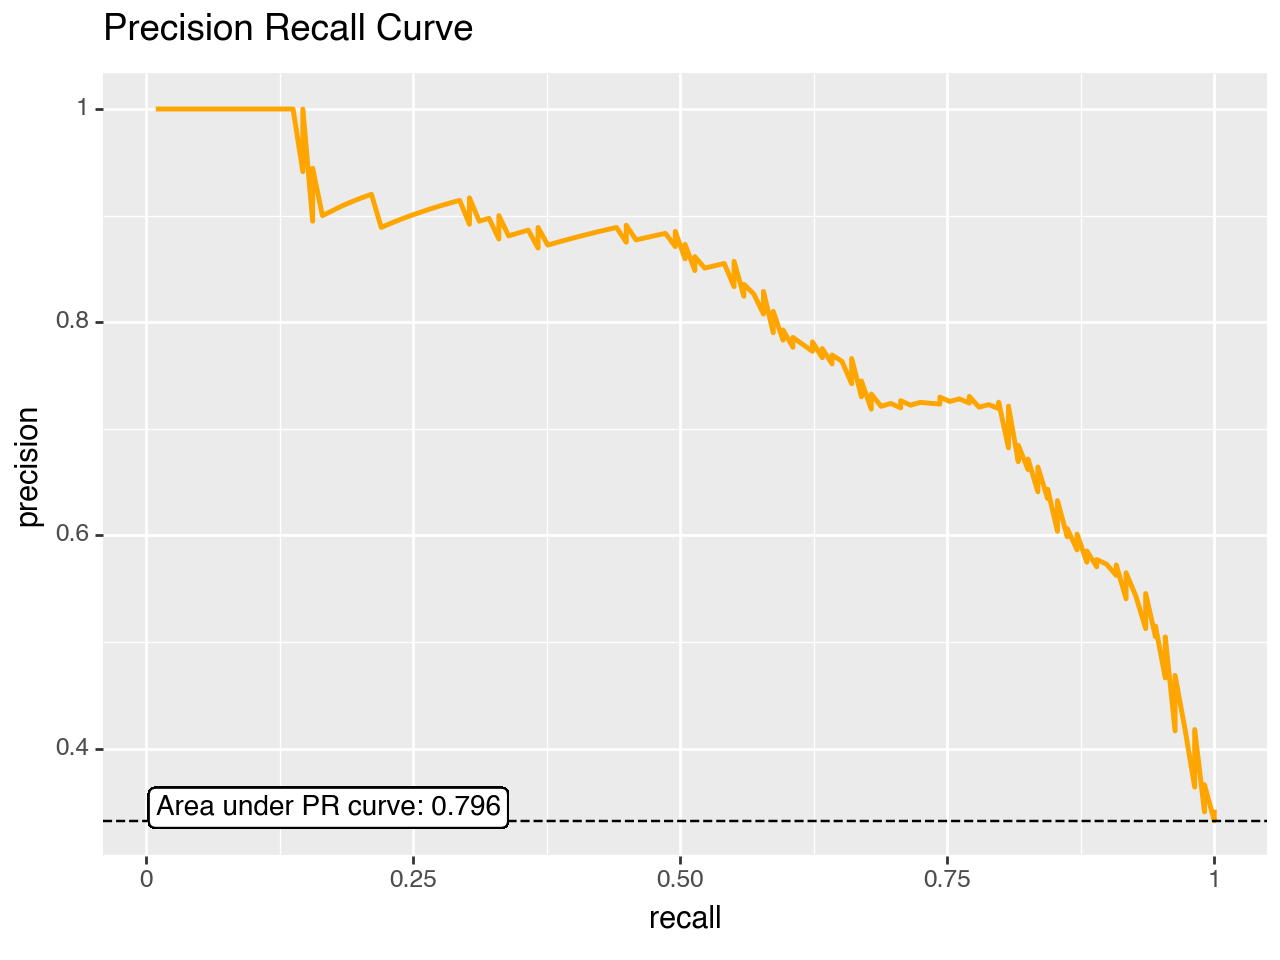

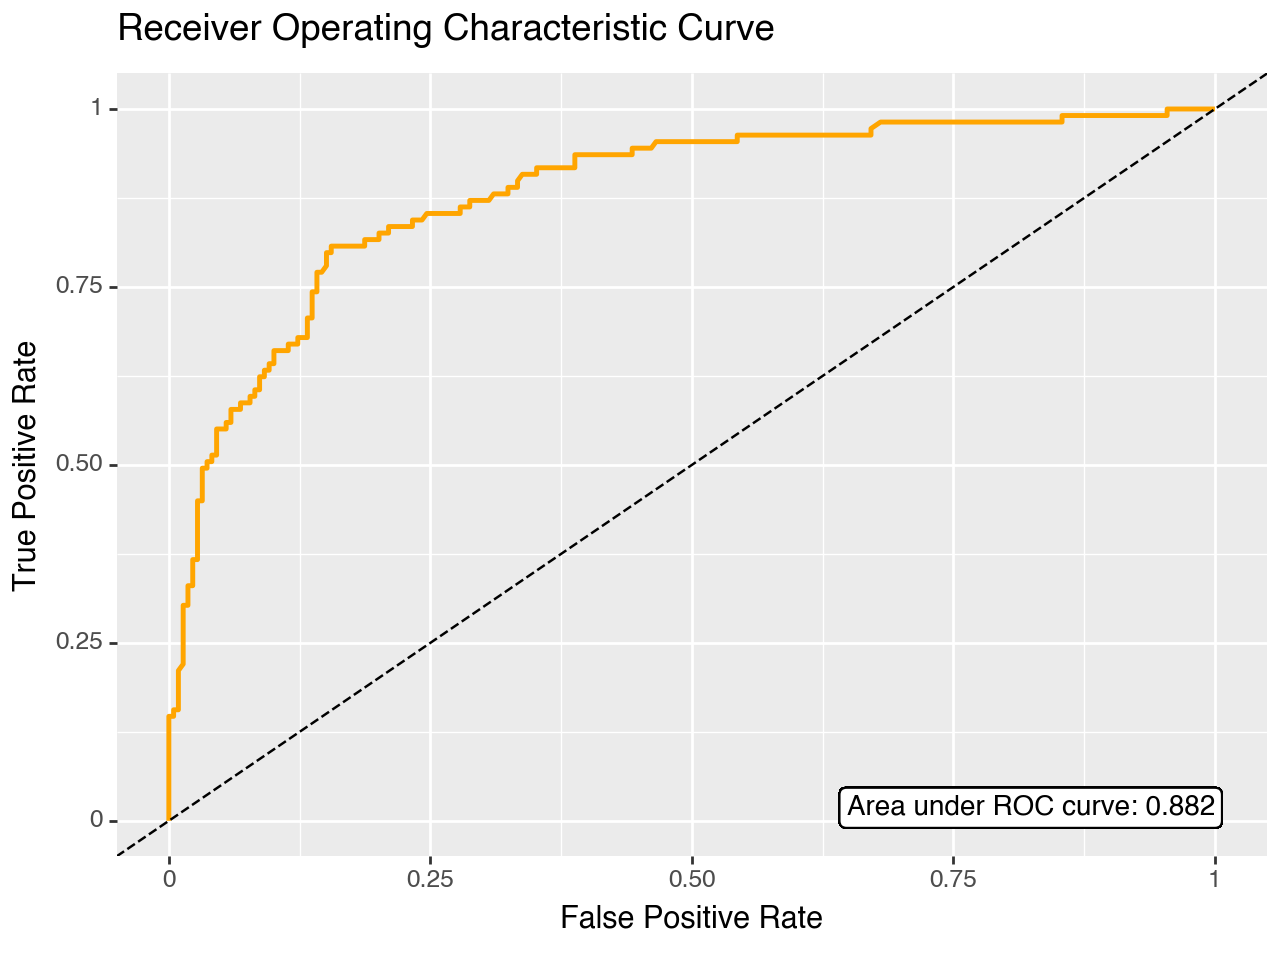

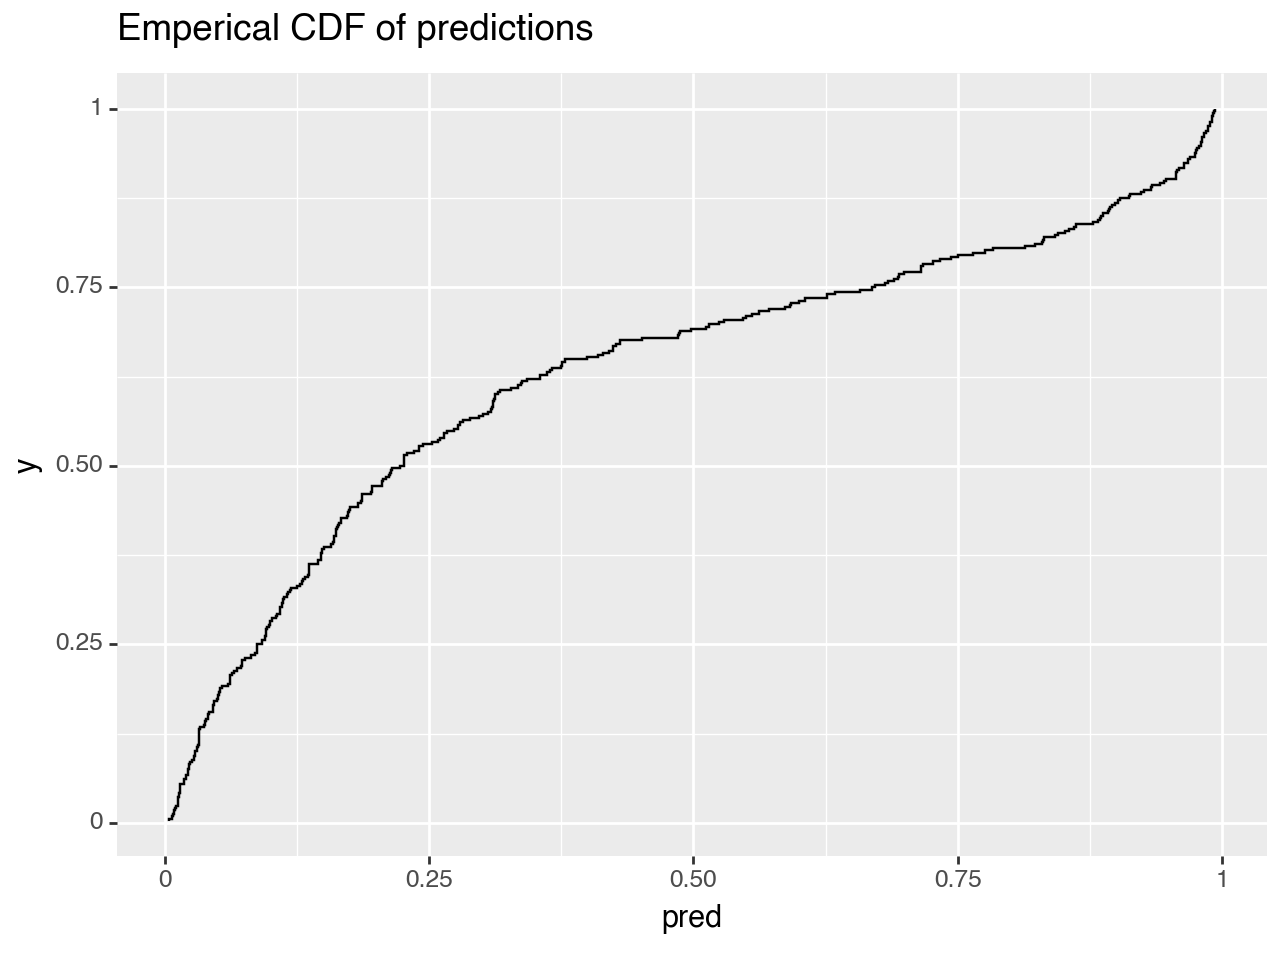

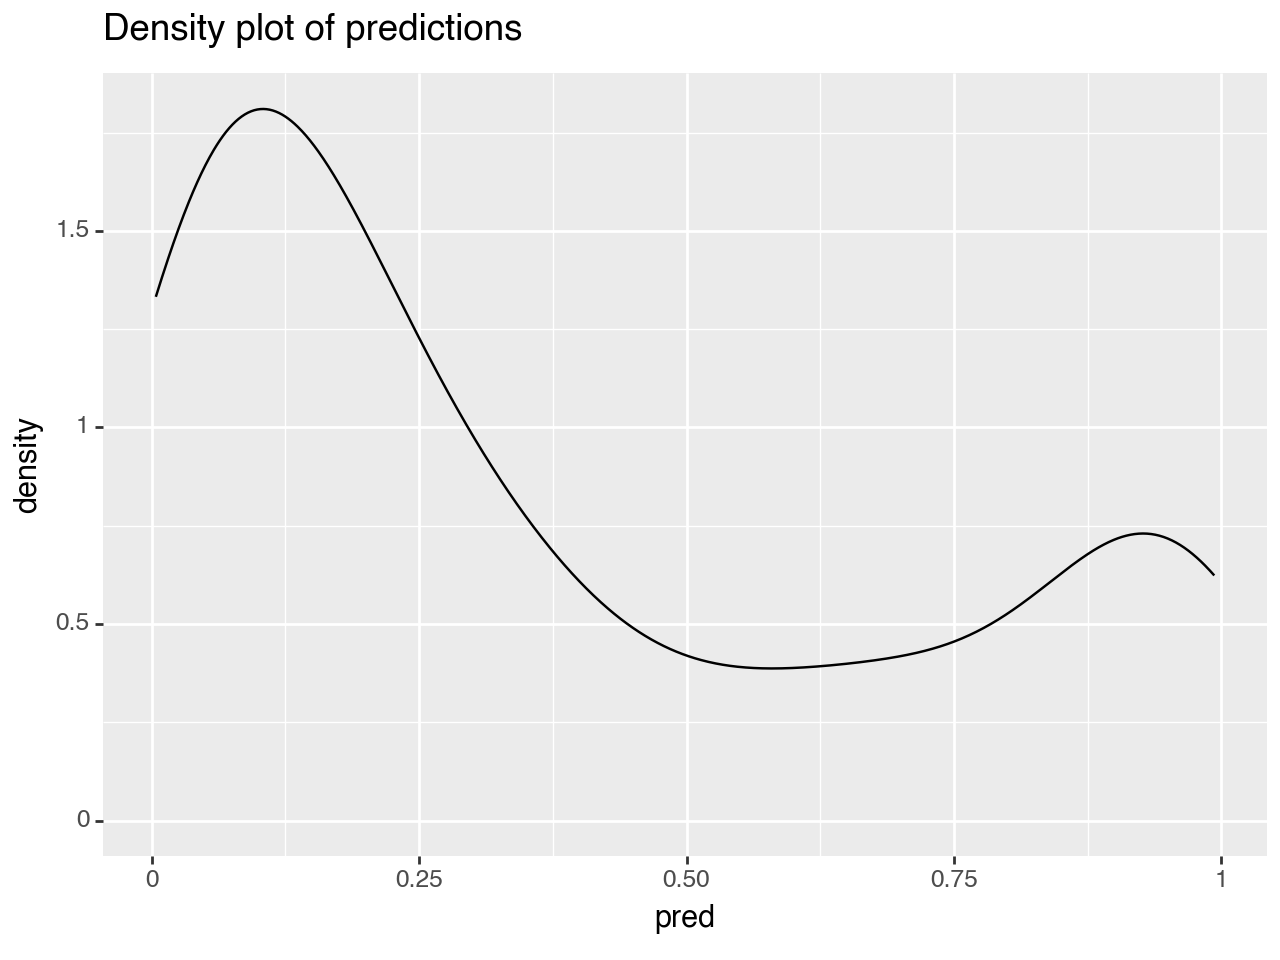

[<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>]

In [20]:
plots

In [21]:
scores

[{'accuracy': 0.8109756097560976,
  'average_precision': 0.8057646727770347,
  'f1_score': 0.7047619047619047},
      precision    recall  threshold
 0     0.332317  1.000000   0.003812
 1     0.333333  1.000000   0.004322
 2     0.334356  1.000000   0.007099
 3     0.335385  1.000000   0.007527
 4     0.336420  1.000000   0.008215
 ..         ...       ...        ...
 284   1.000000  0.045872   0.990712
 285   1.000000  0.036697   0.990946
 286   1.000000  0.027523   0.991020
 287   1.000000  0.018349   0.992400
 288   1.000000  0.009174   0.993267
 
 [289 rows x 3 columns],
           fpr       tpr  threshold
 0    0.000000  0.000000        inf
 1    0.000000  0.009174   0.993267
 2    0.000000  0.146789   0.980587
 3    0.004566  0.146789   0.980051
 4    0.004566  0.155963   0.977813
 ..        ...       ...        ...
 119  0.881279  0.990826   0.023938
 120  0.890411  0.990826   0.022676
 121  0.954338  0.990826   0.012818
 122  0.954338  1.000000   0.012435
 123  1.000000  1.000

## Using GridsearchCV

In [43]:
from scipy.stats import loguniform

rng = np.random.RandomState(1234)

grid_size = 3
grid_learning_rate = loguniform.rvs(0.1, 1.0, size = grid_size)
grid_gamma = rng.uniform(low = 0, high = 1, size = grid_size)
grid_max_depth = list(range(4, 10))
grid_min_child_weight = rng.randint(3, 50, grid_size)
grid_subsample = rng.uniform(0.01, 0.9, size=grid_size)
grid_colsample_bytree = rng.uniform(0.1, 0.9, grid_size)
grid_reg_lambda = loguniform.rvs(1e-9, 1000, size = grid_size)
grid_reg_alpha = loguniform.rvs(1, 100, size=grid_size)
grid_n_estimators = rng.randint(50, 1000, size=grid_size)


In [44]:
%%time 

from sklearn.model_selection import GridSearchCV

param = {
    'clf__learning_rate': grid_learning_rate,
    'clf__gamma': grid_gamma,
    'clf__max_depth': grid_max_depth,
    'clf__min_child_weight': grid_min_child_weight,
    'clf__subsample': grid_subsample,
    'clf__colsample_bytree': grid_colsample_bytree,
    'clf__reg_lambda': grid_reg_lambda,
    'clf__reg_alpha': grid_reg_alpha,
    'clf__n_estimators': grid_n_estimators
}

gridsearch = GridSearchCV(pipe, param_grid=param, cv=skf, n_jobs=-1, scoring='roc_auc', return_train_score=True)
gridsearch.fit(X_train_full, y_train_full)
print('Best score of Grid Search:', gridsearch.best_score_)

Best score of Grid Search: 0.8448147544545849
CPU times: user 40min 11s, sys: 2min 15s, total: 42min 27s
Wall time: 10h 8min 31s


In [ ]:
# pipe['clf']

In [ ]:
# print("Best parameter (CV score=%0.3f):" % gridsearch.best_score_)
# print(gridsearch.best_params_)

# Feature importances

### How do we get feature names?

In [ ]:
pipe.feature_names_in_
pipe.named_steps['encode_cats'].get_feature_names_out()
pipe.named_steps['imputer'].feature_names_in_

### Base XGBoost feature importance 1

In [ ]:
dict_importances = {
    'name': pipe.named_steps['imputer'].get_feature_names_out(),
    #this gets the gain importance get_fscore returns weight type
    'importance': pipe.named_steps['clf'].feature_importances_
}

df_importances = pd.DataFrame(dict_importances)

print(df_importances.sort_values('importance', ascending=False).head())

### Base XGBoost feature importance 2

Explanation: The train() API's method get_score() is defined as:

`get_score(fmap='', importance_type='weight')`

fmap (str (optional)) – The name of feature map file.
importance_type
1. ‘weight’ - the number of times a feature is used to split the data across all trees.
1. ‘gain’ - the average gain across all splits the feature is used in.
1. ‘cover’ - the average coverage across all splits the feature is used in.
1. ‘total_gain’ - the total gain across all splits the feature is used in.
1. ‘total_cover’ - the total coverage across all splits the feature is used in.

In [ ]:
feature_important = pipe.named_steps['clf'].get_booster().get_score(importance_type='gain')

keys = list(feature_important.keys())
values = list(feature_important.values())

data_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_importance.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [ ]:
feature_important

### Permutation based importance

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

In [ ]:
def run_pipeline(pipeline, input, steps):
    """Run an sklearn pipeline down named steps. Returns the output dataframe

    Args:
        pipeline (sklearn pipeline): The pipeline you want to run
        input (pandas dataframe): The input dataframe
        steps (list[str]): the steps you want to run the pipeline down
    """

    for step in steps:
        output = pipeline[step].transform(input)
        input = output

    return(output)

#run_pipeline(pipe, X_test, ['encode_cats', 'scale', 'imputer'])


In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

X_preprocessed = run_pipeline(pipe, X_test, ['encode_cats', 'scale', 'imputer'])
perm_importance = permutation_importance(pipe['clf'], X_preprocessed, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(X_preprocessed.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### Shapley value based importance

In [ ]:
import shap

explainer = shap.TreeExplainer(pipe['clf'])
shap_values = explainer.shap_values(X_preprocessed)
shap.summary_plot(shap_values, input, plot_type="bar")

# Appendix: Annoying times working with sklearn OneHotEncoder

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder()
# X = X[['Sex', 'Pclass', 'Embarked']].copy()
# enc.fit_transform(X).toarray()

In [ ]:
# enc.get_feature_names_out()

In [ ]:
# cat_features = ['Pclass', 'Sex', 'Embarked']
# encoded_features = []
# dfs = [X]

# for df in dfs:
#     for feature in cat_features:
#         encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
#         n = df[feature].nunique()
#         cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
#         encoded_df = pd.XFrame(encoded_feat, columns=cols)
#         encoded_df.index = df.index
#         encoded_features.append(encoded_df)


In [ ]:
# cols 

In [ ]:
# encoded_feat